In [1]:
import sys
sys.path.insert(1, '../src/')

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

import numpy as np
import os
import cv2

#import csv_parse
import classifier

%load_ext autoreload
%autoreload

In [2]:
os.getcwd()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
full_train_df = pd.read_csv(os.getcwd()+'/train_sigmoid.csv')
full_test_df = pd.read_csv(os.getcwd()+'/test_sigmoid.csv')

In [5]:
import ast
def feature_string(row):
    temp = []
    temp2 = ast.literal_eval(row['Label'])
    for k in temp2:
        temp.append(ast.literal_eval(k))
    temp3 = ["Normal", "Opacity", "Pneumonia", "Covid"]
    lab = temp3[np.argmax(np.array(temp2))]
    return lab

In [3]:
#full_train_df['feature_string'] = full_train_df.apply(feature_string,axis = 1).fillna('')
# full_test_df['feature_string'] = full_test_df.apply(feature_string,axis = 1).fillna('')
full_test_df = pd.read_pickle('../notebooks/covid_chexpert_val_df_15cls_large.pkl')

In [4]:
## Build Model
from collections import Counter


classifier_8 = classifier.Classifier(224, 1, 15)#, "chexphoto_challenge", "BCE")
#classifier_8.datagen_init(full_train_df, "../../data")
classifier_8.datagen_init_valid_old(full_test_df, "/bigdisk/data/dataset/")
#classifier_8.build_model(load_previous_weights=False)

Found 1527 validated image filenames belonging to 15 classes.


In [5]:
full_test_df

Path  \
0     CheXpert-v1.0-small/valid/patient64541/study1/...   
1     CheXpert-v1.0-small/valid/patient64542/study1/...   
2     CheXpert-v1.0-small/valid/patient64542/study1/...   
3     CheXpert-v1.0-small/valid/patient64543/study1/...   
4     CheXpert-v1.0-small/valid/patient64544/study1/...   
...                                                 ...   
1522  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1523  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1524  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1525  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1526  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   

                                         feature_string  
0     [Cardiomegaly, Enlarged Cardiomediastinum, Lun...  
1                                     [Support Devices]  
2                                     [Support Devices]  
3     [Edema, Enlarged Cardiomediastinum, Lung Opacity]  
4                                          [No Finding]  
...                                                 ...  
1522                                       [No Finding]  
1523                                       [No Finding]  
1524                                       [No Finding]  
1525                                       [No Finding]  
1526                                       [No Finding]  

[1527 rows x 2 columns]

In [5]:
# predict generator setup

test = pd.Series(classifier_8.validation_generator.labels)
mlb = MultiLabelBinarizer()
y_labels = mlb.fit_transform(test)
# # for k in test:
# #     lab = [0, 0, 0, 0]
# #     lab[k] += 1
# #     y_labels.append(lab)
    
# # y_labels = np.array(y_labels)

# num_steps = 32

# les_xs = []
# les_ys = []
# for k in range(num_steps):
#     x, y = classifier_8.validation_generator.__getitem__(k)
#     les_xs.append(x)
#     les_ys.append(y)

In [38]:
len(les_xs), len(les_ys)

(32, 32)

In [20]:
classifier_8.validation_generator.class_indices
chexphoto_targets = list(classifier_8.validation_generator.class_indices.keys())
chexphoto_targets

['',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Covid',
 'Edema',
 'Enlarged Cardiomediastinum',
 'Lung Lesion',
 'Lung Opacity',
 'No Finding',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices']

In [8]:
## Load weights
import os
import glob
from collections import defaultdict
load_path = ''
weight_files = glob.glob("../model_weights/test*/*")#"#preprocess*")
weight_files.sort()

predictions_in_session = defaultdict(list)

curr = weight_files[0]
for ctr, k in enumerate(weight_files):
    if False:#k.split('-')[0] == curr.split('-')[0]:
        continue
    else:
        print(ctr, "\t", weight_files[ctr])
        curr = k 
indx = int(input("please enter your selection"))
load_path = weight_files[indx]

# weighted_bce_224_run3branchfn(cont_e-6)_weights-14.hdf5 - 0.727
# weighted_bce_224_run3branchfn_weights-07.hdf5 - 0.732

0 	 ../model_weights/test/15cls_BCE_Sigmoid_large_01.hdf5
1 	 ../model_weights/test/15cls_BCE_Sigmoid_large_02.hdf5
2 	 ../model_weights/test/15cls_BCE_Sigmoid_large_03.hdf5
3 	 ../model_weights/test/15cls_BCE_Sigmoid_large_08.hdf5
please enter your selection3


In [9]:
print(load_path)

if os.path.exists("../predictions/"+load_path.split('/')[-1][:-5]+".npy"):
    y_pred_keras = np.load("../predictions/"+load_path.split('/')[-1][:-5]+".npy")
    print("predictions_loaded")

else:
    try:
        classifier_8.build_model(load_previous_weights=False, freeze_cnn=False)
        classifier_8.model.load_weights(load_path)
        print('\n\nWeights successfuly loaded\n\n')
        classifier_8.validation_generator.reset()
        y_pred_keras = classifier_8.model.predict_generator(classifier_8.validation_generator,verbose = 1,steps=classifier_8.validation_generator.n/classifier_8.validation_generator.batch_size)
        np.save("../predictions/"+load_path.split('/')[-1][:-5]+".npy", y_pred_keras)
    except:
        print('Weights not loaded')
    

../model_weights/test/15cls_BCE_Sigmoid_large_08.hdf5


 Pretrained weights Loaded




Weights successfuly loaded


Instructions for updating:
Please use Model.predict, which supports generators.
32/31 [==============================] - 10s 319ms/step


In [10]:
y_pred_keras.shape

(1527, 15)

In [15]:
y_preds = []
for k in range(len(les_xs)):
    y_pred = classifier_8.model.predict(les_xs[k])
    y_preds.append(y_pred)

NameError: name 'les_xs' is not defined

In [11]:
len(y_preds), len(y_preds[0]), y_preds[0][0].shape

NameError: name 'y_preds' is not defined

In [42]:
y_labels_2cls = []
for k in range(32):
    for l in range(64):
        y_labels_2cls.append(les_ys[k][0][l])
        
y_preds_2cls = []
for k in range(32):
    for l in range(64):
        y_preds_2cls.append(y_preds[k][0][l])

In [43]:
len(y_preds_2cls)

y_labels = np.array(y_labels_2cls)
y_pred_keras = np.array(y_preds_2cls)

In [28]:
classifier_8.validation_generator.class_indices
_classes = [
'',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Covid',
 'Edema',
 'Enlarged Cardiomediastinum',
 'Lung Lesion',
 'Lung Opacity',
 'No Finding',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices']
#print(chexphoto_targets)

['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


# ROC and PR curves

['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']
0.9644248807567745
0.5647090879778234


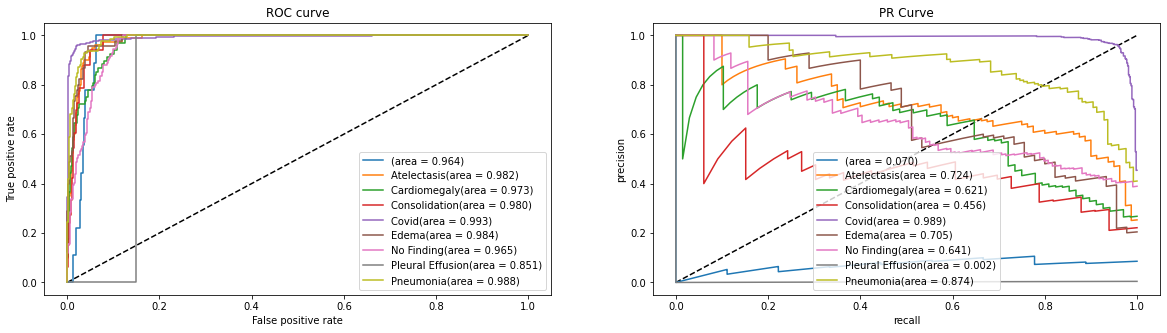

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn

chexphoto_targets = ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation',
                     'Covid', 'Edema', 'No Finding', 'Pleural Effusion',
                     'Pneumonia']#["Covid", "Normal"]#, 'Opacity', 'Pneumonia']
f, ax = plt.subplots(1, 2, figsize=(20,5))
AUCs = []

ax[0].plot([0, 1], [0, 1], 'k--')

ax[1].plot([0, 1], [0, 1], 'k--')

print(chexphoto_targets)

for ii in range(len(chexphoto_targets)):#[0, 1]:#, 2, 3]:
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,ii], y_pred_keras[:,ii])
    auc_keras = auc(fpr_keras, tpr_keras)
    AUCs.append(auc_keras)
    ax[0].plot(fpr_keras, tpr_keras, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve')
ax[0].legend(loc='best')
print(sum(AUCs)/len(AUCs))


import sklearn
AUCs = []
for ii in range(len(chexphoto_targets)):#[0, 1]:#, 2, 3]:
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_labels[:, ii], y_pred_keras[:, ii])
    auc_keras = auc(recall, precision)
    AUCs.append(auc_keras)
    ax[1].plot(recall, precision, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))


ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision')
ax[1].set_title('PR Curve')
ax[1].legend(loc='best')
print(sum(AUCs)/len(AUCs))
plt.show()


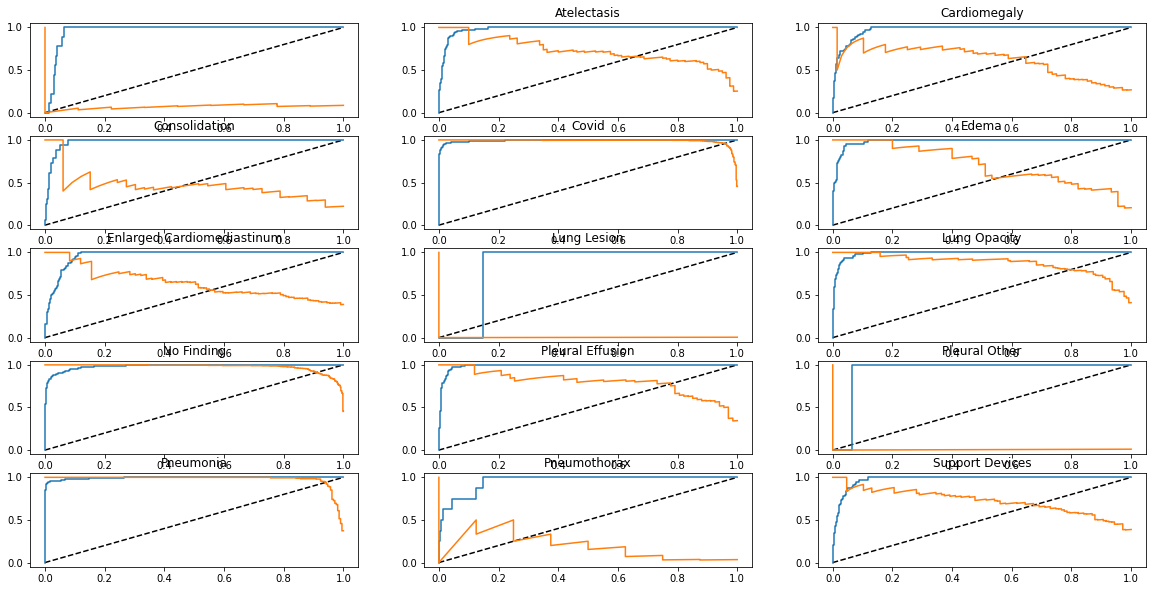

In [22]:
plot_individual_classes = True
if plot_individual_classes:
    f, ax = plt.subplots(5, 3, figsize=(20,10))
    _div = 3
    ROC_AUCs = []
    PR_AUCs = []
    thresholds = []
    fprs = []
    tprs = []

    for ii in [0, 1, 2, 3, 4, 5, 6, 7, 8,9 , 10, 11, 12, 13, 14]:
        #print(ii//_div, ii%_div)#, 4, 5, 6, 7]:#range(0, y_pred_keras.shape[1]):
        ax[ii//_div][ii%_div].plot([0, 1], [0, 1], 'k--')
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,ii], y_pred_keras[:,ii])
        auc_keras = auc(fpr_keras, tpr_keras)
        ROC_AUCs.append(auc_keras)
        thresholds.append(thresholds_keras)
        fprs.append(fpr_keras)
        tprs.append(tpr_keras)
        ax[ii//_div][ii%_div].plot(fpr_keras, tpr_keras, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))

        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_labels[:, ii], y_pred_keras[:, ii])
        auc_keras = auc(recall, precision)
        PR_AUCs.append(auc_keras)
        ax[ii//_div][ii%_div].plot(recall, precision, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))
        ax[ii//_div][ii%_div].set_title(chexphoto_targets[ii])

    plt.show()

In [17]:
len(chexphoto_targets)

9

In [77]:
covid_pred = y_pred_keras[:, 7]
covid_label = y_labels[:, 7]

In [78]:
covid_pos = np.where(covid_label == 1)[0]
the_pos = []
for ctr, k in  enumerate(covid_pos):
    if covid_pred[ctr] > 0.65:
        the_pos.append(k)

In [73]:
the_pos[0:100]

[130, 163]

In [79]:
for k in the_pos:
    print(full_test_df.iloc[k]['Path'])
    

CheXpert-v1.0-small/valid/patient64619/study1/view1_frontal.jpg
CheXpert-v1.0-small/valid/patient64682/study1/view1_frontal.jpg
CheXpert-v1.0-small/valid/patient64688/study1/view1_frontal.jpg
CheXpert-v1.0-small/valid/patient64692/study1/view1_frontal.jpg


# Setting thresholds and classification reports

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [24]:
len(tprs)

15

In [29]:
 # set thresholds
desired_recall = [0.940]*9#, 0.7, 0.67, 0.8, 0.8, 0.8, 0.85, 0.6]
desired_recall[6] = 0.7
thresh = []
for k in range(len(desired_recall)):
    curr_tpr = tprs[k]
    curr_thresh = thresholds[k]
    for ctr, i in enumerate(curr_tpr):
        if i > desired_recall[k]:
            thresh.append(curr_thresh[ctr])
            break

In [20]:
thresh

[0.031770363,
 0.091329604,
 0.039110698,
 0.07720213,
 0.13892841,
 0.051437944,
 0.04331073,
 0.14046013,
 2.1525184e-05]

In [26]:
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresh = []
for k in range(15):
    thresholds_n = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score(y_labels[:,k], to_labels(y_pred_keras[:,k], t)) for t in thresholds_n]
    ix = np.argmax(scores)
    thresh.append(thresholds_n[ix])

In [27]:
thresh

[0.026000000000000002,
 0.233,
 0.134,
 0.199,
 0.092,
 0.273,
 0.069,
 0.025,
 0.241,
 0.8250000000000001,
 0.298,
 0.021,
 0.636,
 0.72,
 0.332]

In [30]:
mean_sen = []
mean_spec = []
y_preds = []
for k in range(len(thresh)):
    print(chexphoto_targets[k])
    print("--------------------")
    y_pred = np.copy(y_pred_keras[:, k])
    y_pred[y_pred > thresh[k]] = 1
    y_pred[y_pred != 1] = 0
    tn, fp, fn, tp = confusion_matrix(y_labels[:, k], y_pred).ravel()
    y_preds.append(y_pred)
    print(confusion_matrix(y_labels[:, k], y_pred))
    print(f"sensitivity = {tp/(tp+fn)}")
    print(f"specificity = {tn/(tn+fp)}")
#     print(classification_report(y_labels[:, k], y_pred))
    print("------------------------------------------------------------------------------------------")
    mean_sen.append(tp/(tp+fn))
    mean_spec.append(tn/(tn+fp))
    
print(sum(mean_sen)/len(mean_sen))
print(sum(mean_spec)/len(mean_spec))


--------------------
[[1422   96]
 [   1    8]]
sensitivity = 0.8888888888888888
specificity = 0.9367588932806324
------------------------------------------------------------------------------------------
Atelectasis
--------------------
[[1368   79]
 [   5   75]]
sensitivity = 0.9375
specificity = 0.9454042847270214
------------------------------------------------------------------------------------------
Cardiomegaly
--------------------
[[1312  147]
 [   5   63]]
sensitivity = 0.9264705882352942
specificity = 0.8992460589444825
------------------------------------------------------------------------------------------
Consolidation
--------------------
[[1378  116]
 [   1   32]]
sensitivity = 0.9696969696969697
specificity = 0.9223560910307899
------------------------------------------------------------------------------------------
Covid
--------------------
[[968  17]
 [ 30 512]]
sensitivity = 0.9446494464944649
specificity = 0.9827411167512691
------------------------------------

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def return_metrics(cnf_matrix_chex):
    FP = cnf_matrix_chex.sum(axis=0) - np.diag(cnf_matrix_chex) 
    FN = cnf_matrix_chex.sum(axis=1) - np.diag(cnf_matrix_chex)
    TP = np.diag(cnf_matrix_chex)
    TN = cnf_matrix_chex.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return TPR, TNR



In [33]:
np.array(y_labels).shape, np.transpose(np.array(y_preds)).shape

((1527, 9), (1527, 9))

In [34]:
cnf_matrix = confusion_matrix(np.array(y_labels), np.transpose(np.array(y_preds)))#, labels=["Covid", "Normal", 'Opacity', 'Pneumonia'], binary=False)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
spec, sens = return_metrics(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=chexphoto_targetshoto_targets,
                      title='Chexpert weights \n sens: ' + str(sens[0]) + "\n spec: " + str(spec[0]))

ValueError: multilabel-indicator is not supported

In [59]:
print(classification_report(np.array(y_t), np.array(y_p)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1506
           1       0.96      0.95      0.96       542

    accuracy                           0.98      2048
   macro avg       0.97      0.97      0.97      2048
weighted avg       0.98      0.98      0.98      2048



In [54]:
print(classification_report(np.array(y_t), np.array(y_p)))

              precision    recall  f1-score   support

           0       0.92      0.82      0.86       542
           1       0.87      0.96      0.91      1528
           2       0.91      0.85      0.88       901
           3       1.00      0.72      0.83       201

    accuracy                           0.89      3172
   macro avg       0.92      0.84      0.87      3172
weighted avg       0.90      0.89      0.89      3172



# Plotting client side results 

In [11]:
classifier_8.build_model(load_previous_weights=False, if_grad=True)
try:
    classifier_8.model.load_weights(load_path)
    print('\n\nWeights successfuly loaded\n\n')
    #classifier_8.test_generator.reset()
    #y_pred_keras = classifier_8.model.predict_generator(classifier_8.test_generator,verbose = 1,steps=classifier_8.test_generator.n/classifier_8.test_generator.batch_size)
    #np.save("../predictions/"+load_path.split('/')[-1][:-5]+".npy", y_pred_keras)
except:
    print('Weights not loaded')
    



 Pretrained weights Loaded




Weights successfuly loaded




In [12]:
classifier_8.model.output

[<tf.Tensor 'dense_3/Sigmoid:0' shape=(None, 9) dtype=float32>,
 <tf.Tensor 'relu/Relu:0' shape=(None, 7, 7, 1024) dtype=float32>]

In [13]:
def getCamMask(image, cam, thrshld=0.95):
    h, w, ch = image.shape
    maskCam = np.zeros((h, w))
    maskCam[cam > thrshld * np.max(cam)] = 1.0
    return maskCam

def getFirstNblobs(label, ntop=1):
    '''
    Tis function extract first N blobs with largest area from the given mask
    :param label:
    :param ntop:
    :return:
    '''
    N = np.max(label) + 1
    if ntop == None:
        ntop = N
    areas = np.zeros((N, 1))
    for k in range(0, N):
        areas[k] = np.sum(label == (k + 1))
    indx_sorted = np.flipud(np.argsort(areas, axis=0))
    label_indx = []
    if N >= ntop:
        for k in range(0, ntop):
            if areas[indx_sorted[k]] > 0:
                label_indx.append(indx_sorted[k] + 1)
    label_out = np.zeros(label.shape)
    for k in label_indx:
        label_out[label == k] = 1
    return label_out

def getAnnotatedImage(img, mask, ntop=2):
    '''
    This function takes image and mask of shape (m, n) and returns (m, n, 3) annotated image
    :param img:
    :param mask:
    :return:
    '''
    imgAnno = np.copy(img / np.max(img) * 255).astype('int')
    #imgAnno = np.expand_dims(imgAnno, -1)
    #imgAnno = np.concatenate((imgAnno, imgAnno, imgAnno), axis=-1)
    maskLabel = label(mask)
    maskLabel = getFirstNblobs(maskLabel, ntop=ntop)
    maskNew = np.zeros(maskLabel.shape)
    maskNew[maskLabel > 0.0] = 1.0
    contours = find_contours(maskLabel, 0.8)
    for n, contour in enumerate(contours):
        x, y = np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')
        imgAnno[x, y, :] = np.array([255, 0, 0], dtype='int')
    return imgAnno.astype(np.uint8), maskNew

[1.7019827e-03 1.3185360e-03 4.1824550e-04 5.9437228e-04 8.3353955e-01
 3.3687122e-04 3.1476367e-01 4.7895923e-04 9.4844017e-04]
Pred = Covid  with  0.834
Pred = No Finding  with  0.315
Pred =   with  0.002

GT = Covid

 4 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


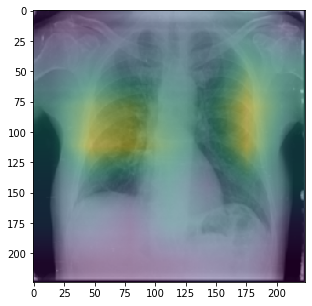




[1.21829465e-01 8.53651240e-02 1.12556562e-01 1.23947533e-02
 2.74975100e-05 8.08790252e-02 6.13759995e-01 2.32990254e-02
 9.70683759e-05]
Pred = No Finding  with  0.614
Pred =   with  0.122
Pred = Cardiomegaly  with  0.113

GT = 

 6 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


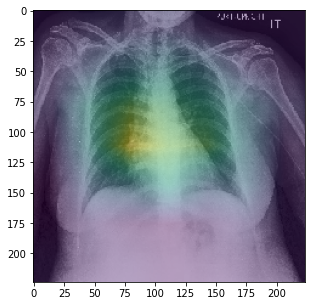




[1.5581725e-03 4.8084813e-03 1.8356913e-03 3.1041501e-03 9.9854088e-01
 2.9469905e-03 6.0450425e-04 3.6866094e-03 1.2604501e-04]
Pred = Covid  with  0.999
Pred = Atelectasis  with  0.005
Pred = Pleural Effusion  with  0.004

GT = Covid

 4 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


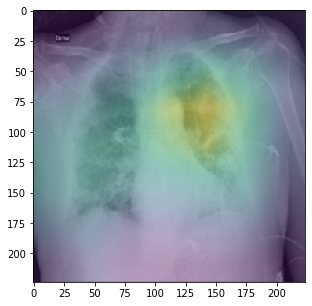




[5.1803244e-03 2.3269441e-03 2.1664763e-03 1.5806188e-03 9.6629357e-01
 3.4037235e-03 8.3657764e-02 1.0141975e-03 2.2342212e-04]
Pred = Covid  with  0.966
Pred = No Finding  with  0.084
Pred =   with  0.005

GT = Covid

 4 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


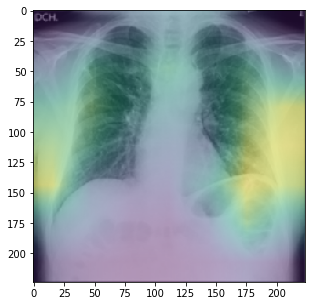




[2.6530059e-02 4.6367843e-02 1.9354526e-02 3.6974896e-02 1.1074425e-01
 5.0464505e-03 5.9229141e-01 7.7993106e-03 7.3492949e-05]
Pred = No Finding  with  0.592
Pred = Covid  with  0.111
Pred = Atelectasis  with  0.046

GT = Covid

 6 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


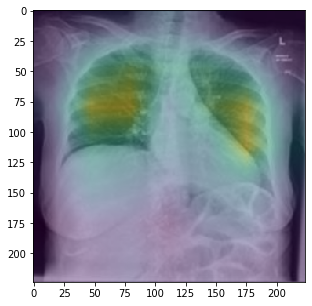




[4.4491995e-02 3.8710171e-01 2.4500166e-01 1.0215290e-01 7.0747003e-05
 5.4267430e-01 9.7233638e-02 2.3882040e-01 1.9795625e-04]
Pred = Edema  with  0.543
Pred = Atelectasis  with  0.387
Pred = Cardiomegaly  with  0.245

GT = Atelectasis

 5 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


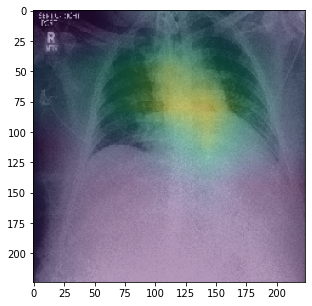




[9.1010116e-02 3.5624838e-01 3.3120751e-02 8.0948398e-02 1.6678980e-05
 2.8239105e-02 3.3932978e-01 1.7170404e-01 1.6928614e-05]
Pred = Atelectasis  with  0.356
Pred = No Finding  with  0.339
Pred = Pleural Effusion  with  0.172

GT = Atelectasis

 1 ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Covid', 'Edema', 'No Finding', 'Pleural Effusion', 'Pneumonia']


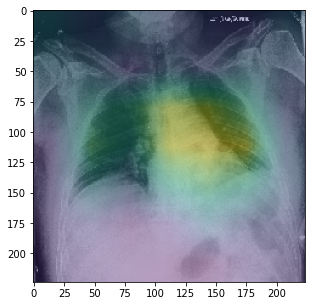

In [17]:
from IPython.display import clear_output
from skimage import filters
from skimage.measure import label, find_contours
import tensorflow as tf
chexphoto_targets = chexphoto_targets#_classes#[ "Normal", "Covid"]#, 'Opacity', 'Pneumonia']
def plotImageGroup(randomIndices):
    f,ax = plt.subplots(2, 5, figsize=(20, 10))
    for ctr, k in enumerate(randomIndices):
        ax[ctr//5][ctr%5].imshow(classifier_8.test_generator[k//48][0][k%48])
    plt.show()
    return f

def get_top3(arr):
    return arr.argsort()[-3:][::-1]
    
    
randomIndices = np.random.randint(0, 541, 7)#[1001, 1002, 303, 404, 505, 606, 707]#_2indices + _1indices[0:1]
inds = [0, 1, 2, 3, 4, 5, 6]#, 7, 8, 9]
# f, ax = plt.subplots(5, 2, figsize=(16, 32))

for ctr, index in enumerate(inds):
    x = classifier_8.validation_generator[randomIndices[index]//48][0][randomIndices[index]%48]
    #print(classifier_8.validation_generator.fnames[64*block+index])
    CAT_CLASS_INDEX = [0,1,2,3,4,5,6,7,8]#[np.argmax(y_pred_keras[index])]#, 6, 7]
    cams = []
    for class_ind in CAT_CLASS_INDEX:
        with tf.GradientTape() as tape:
            predictions, conv_outputs = classifier_8.model(np.expand_dims(x, axis=0))
            loss = predictions[:, class_ind]

        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]
        

        gate_f = tf.cast(output > 0, 'float32')
        gate_r = tf.cast(grads > 0, 'float32')
        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = np.zeros(output.shape[0: 2], dtype = np.float32)
        
        for i, w in enumerate(weights):
            cam += w * output[:, :, i]    

        cams.append(cam)
        print("%s classes extracted"%class_ind, end="\r", flush=True)
    
    predictions = predictions.numpy()[0]
    print(predictions)
    top3 = get_top3(predictions)
    
    #top3 = predictions[top3]
    _print_this = ""
    for j in range(3):
        _curr = "Pred = " + str(chexphoto_targets[top3[j]]) + "  with  " + "{:0.3f}".format(float(predictions[top3[j]])) + "\n"
        _print_this += _curr
    print(_print_this)
#     print("Pred = " + str(chexphoto_targets[np.argmax(predictions)]) + "  with  " +
#           "{:0.3f}".format(float(predictions[np.argmax(predictions)])))
    print("GT = " + str(chexphoto_targets[np.argmax(classifier_8.validation_generator[randomIndices[index]//48][1][randomIndices[index]%48])]))
    cam_mean = np.array(cams[top3[0]])
    print("\n",top3[0], chexphoto_targets)
    #cam = np.mean(cam_mean, axis=0)
    cam = cv2.resize(cam_mean, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)


    img = x
    #img = np.uint8(img)
    #f,ax = plt.subplots(2, 4, figsize=(20, 10))

    camMask = getCamMask(img, heatmap)#filters.gaussian(heatmap, sigma=3))
    imgAnno, maskCam = getAnnotatedImage(img, camMask , ntop=None)
    
    fig = plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.4)
#     for m in [chexphoto_targets[np.argmax(predictions)]]:
#         print(y_pred_keras[randomIndices[index]])
#         if m != 'Other' and y_pred_keras[randomIndices[index], chexphoto_targets.index(m)] > 0.65:
#             if m == 'No Finding':
#                 m = 'Healthy'
#                 m_f = 'No Finding'
#             else:
#                 m_f = m
#             plt.plot(0, 0, label=m+'({:0.1f}%)'.format(y_pred_keras[randomIndices[index], chexphoto_targets.index(m_f)]*100))
#     plt.legend(loc='best')
    plt.show()
    print("\n\n")
    
    #fig.savefig('./'+patient+'_'+str(index)+'.jpg', dpi = 100)

#     #fig, ax = plt.subplots(figsize=(7, 7))
#     ax[ctr//2][ctr%2].imshow(imgAnno)
#     ax[ctr//2][ctr%2].imshow(heatmap_mean, alpha=0.4)
#     for m in tps[randomIndices[index]]:
#         if m != 'Other' and y_pred_keras[randomIndices[index], chexphoto_targets.index(m)] > 0.65:
#             if m == 'No Finding':
#                 m = 'Healthy'
#                 m_f = 'No Finding'
#             else:
#                 m_f = m
#             ax[ctr//2][ctr%2].plot(0, 0, label=m+'({:0.1f}%)'.format(y_pred_keras[randomIndices[index], chexphoto_targets.index(m_f)]*100))
#     ax[ctr//2][ctr%2].legend(loc='best')

# plt.show()
    

In [16]:
classifier_8.validation_generator.isRandRot

False

# Random stuff

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


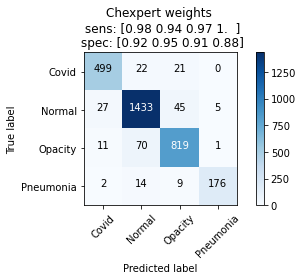

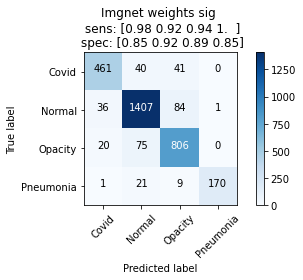

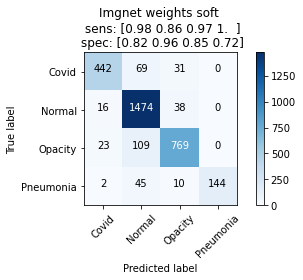

In [42]:
def return_metrics(cnf_matrix_chex):
    FP = cnf_matrix_chex.sum(axis=0) - np.diag(cnf_matrix_chex) 
    FN = cnf_matrix_chex.sum(axis=1) - np.diag(cnf_matrix_chex)
    TP = np.diag(cnf_matrix_chex)
    TN = cnf_matrix_chex.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return TPR, TNR




cnf_matrix_chex = np.array([[ 499, 22,   21,    0],
 [  27, 1433,   45, 5],
 [  11,   70 , 819,    1],
 [   2,   14,    9,  176]])

cnf_matrix_sig_imgnet= np.array([[ 461 ,  40  , 41 ,   0],
 [  36, 1407,   84 ,   1],
 [  20 ,  75,  806  ,  0],
 [   1 ,  21 ,   9  ,170]])

cnf_matrix_soft_imgnet = np.array([[ 442 ,  69,   31,    0],
 [  16 ,1474  , 38  ,  0],
 [  23 , 109  ,769 ,   0],
 [   2 ,  45  , 10 , 144]])



plt.figure()
spec, sens = return_metrics(cnf_matrix_chex)
plot_confusion_matrix(cnf_matrix_chex, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Chexpert weights \n sens: ' + str(sens) + "\n spec: " + str(spec))
plt.figure()
spec, sens = return_metrics(cnf_matrix_sig_imgnet)
plot_confusion_matrix(cnf_matrix_sig_imgnet, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Imgnet weights sig \n sens: ' + str(sens) + "\n spec: " + str(spec))
plt.figure()
spec, sens = return_metrics(cnf_matrix_soft_imgnet)
plot_confusion_matrix(cnf_matrix_soft_imgnet, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Imgnet weights soft \n sens: ' + str(sens) + "\n spec: " + str(spec))



In [49]:
## Chexpert Weights
                precision    recall  f1-score   support

           0       0.93      0.92      0.92       542
           1       0.93      0.95      0.94      1510
           2       0.92      0.91      0.91       901
           3       0.97      0.88      0.92       201

    accuracy                           0.93      3154
   macro avg       0.94      0.91      0.92      3154
weighted avg       0.93      0.93      0.93      3154


Counter({'Other': 19388,
         'Pleural Effusion': 12733,
         'Atelectasis': 9819,
         'Edema': 9817,
         'Cardiomegaly': 4040,
         'No Finding': 3009,
         'Consolidation': 2077,
         'Pneumonia': 809})

Confusion matrix, without normalization
[[ 499   22   21    0]
 [  27 1433   45    5]
 [  11   70  819    1]
 [   2   14    9  176]]


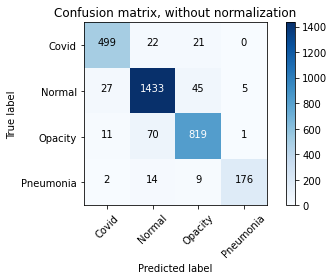

In [6]:
## Chexpert Weights

cnf_matrix = np.array([[ 499, 22,   21,    0],
 [  27, 1433,   45, 5],
 [  11,   70 , 819,    1],
 [   2,   14,    9,  176]])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Confusion matrix, without normalization')

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       542
           1       0.91      0.92      0.92      1528
           2       0.86      0.89      0.88       901
           3       0.99      0.85      0.91       201

    accuracy                           0.90      3172
   macro avg       0.91      0.88      0.89      3172
weighted avg       0.90      0.90      0.90      3172

Confusion matrix, without normalization
[[ 461   40   41    0]
 [  36 1407   84    1]
 [  20   75  806    0]
 [   1   21    9  170]]


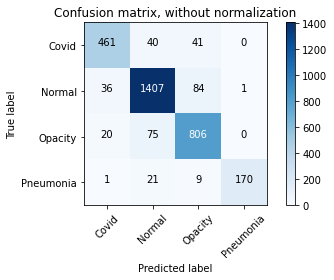

In [17]:
## Simoid Imagenet

cnf_matrix = confusion_matrix(np.array(y_t), np.array(y_p))#, labels=["Covid", "Normal", 'Opacity', 'Pneumonia'], binary=False)

print(classification_report(np.array(y_t), np.array(y_p)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Confusion matrix, without normalization')


              precision    recall  f1-score   support

           0       0.92      0.82      0.86       542
           1       0.87      0.96      0.91      1528
           2       0.91      0.85      0.88       901
           3       1.00      0.72      0.83       201

    accuracy                           0.89      3172
   macro avg       0.92      0.84      0.87      3172
weighted avg       0.90      0.89      0.89      3172

Confusion matrix, without normalization
[[ 442   69   31    0]
 [  16 1474   38    0]
 [  23  109  769    0]
 [   2   45   10  144]]


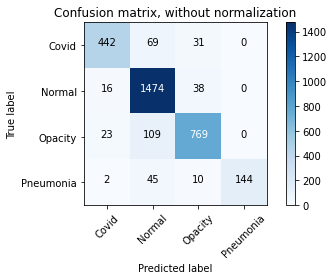

In [19]:
## Softmax Imagenet

cnf_matrix = confusion_matrix(np.array(y_t), np.array(y_p))#, labels=["Covid", "Normal", 'Opacity', 'Pneumonia'], binary=False)

print(classification_report(np.array(y_t), np.array(y_p)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Confusion matrix, without normalization')